<a href="https://colab.research.google.com/github/siposroland/cvs_hw_3d/blob/master/CV_HW_TASK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# installing Requirements
!pip install torch torchvision

# Download dataset

In [0]:
# Homework dataset
!wget http://deeplearning.iit.bme.hu/CVS/HW.zip
!unzip -qq HW.zip
!rm HW.zip

# Traffic Sign Classification set
!wget http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
!unzip -qq trafficSignsHW.zip
!rm trafficSignsHW.zip

Class names


In [0]:
classNames = ['traffic sign', 'vehicle', 'cactus']
subclassNames = [
    ['Bump', 'Bumpy road', 'Bus stop', 'Children', 'Crossing (blue)', 'Crossing (red)', 'Cyclists',
     'Danger (other)', 'Dangerous left turn', 'Dangerous right turn', 'Give way', 'Go ahead', 'Go ahead or left',
     'Go ahead or right', 'Go around either way', 'Go around left', 'Go around right', 'Intersection', 'Limit 100',
     'Limit 120', 'Limit 20', 'Limit 30', 'Limit 50', 'Limit 60', 'Limit 70', 'Limit 80', 'Limit 80 over',
     'Limit over', 'Main road', 'Main road over', 'Multiple dangerous turns', 'Narrow road (left)',
     'Narrow road (right)', 'No entry', 'No entry (both directions)', 'No entry (truck)', 'No stopping', 'No takeover',
     'No takeover (truck)', 'No takeover (truck) end', 'No takeover end', 'No waiting', 'One way road',
     'Parking', 'Road works', 'Roundabout', 'Slippery road', 'Stop', 'Traffic light', 'Train crossing',
     'Train crossing (no barrier)', 'Wild animals', 'X - Priority', 'X - Turn left', 'X - Turn right'],
    ['SUV','truck','plane'],
    ['happy','sad','angry','evil']
]

# Neural network

In [0]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch import optim

# Convolutional module (Conv+ReLU+BatchNorm)
class Conv(nn.Module):
  def __init__(self, in_channels, channels,kernel_size=3, stride=1):   #kernel_size=3
     super(Conv, self).__init__()
     self.conv = nn.Conv2d(in_channels, channels, kernel_size, stride=stride, padding=kernel_size//2, bias=False)   #padding=1
     self.bn = nn.BatchNorm2d(channels)
  def forward(self,x):
     return self.bn(torch.relu(self.conv(x)))
  

class ConvNet(nn.Module):
  def __init__(self, base_channels=16, in_channels=3, num_classes=55):  #in_channels=4
      super(ConvNet, self).__init__()   
      
      self.c11 = Conv(in_channels, base_channels)
      self.c12 = Conv(base_channels, base_channels)
      self.d1 = Conv(base_channels, base_channels*2, stride=2)

      self.c21 = Conv(base_channels*2, base_channels*2)
      self.c22 = Conv(base_channels*2, base_channels*2)
      self.d2 = Conv(base_channels*2, base_channels*4, stride=2)
        
      self.c31 = Conv(base_channels*4, base_channels*4)
      self.c32 = Conv(base_channels*4, base_channels*4)
      self.d3 = Conv(base_channels*4, base_channels*8, stride=2)
        
      self.c41 = Conv(base_channels*8, base_channels*8)
      self.c42 = Conv(base_channels*8, base_channels*8)
      self.d4 = Conv(base_channels*8, base_channels*16, stride=2)
        
      self.c51 = Conv(base_channels*16, base_channels*16)
      self.c52 = Conv(base_channels*16, base_channels*16)
      self.d5 = Conv(base_channels*16, base_channels*32, stride=2)
      # Input image is 32x32 -> after 5 downscaling the activation map is 1x1
      
      # Classifier is a convolution that produces num_classes class scores
      self.classifier = nn.Conv2d(base_channels*32,num_classes, 1) #kernel_size=1

  def forward(self,x):
        # Class all the layers
        x = self.d1(self.c12(self.c11(x)))
        x = self.d2(self.c22(self.c21(x)))
        x = self.d3(self.c32(self.c31(x)))
        x = self.d4(self.c42(self.c41(x)))
        x = self.d5(self.c52(self.c51(x)))
        return torch.squeeze(self.classifier(x))


haveCuda = torch.cuda.is_available()

#DATA AUGMENTATION
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
     #transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)) # mean = 0 and standard-deviation = 1
])

transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    # Random perturbance of brightness, contrast and color
    transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.3,hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
    #transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)) # mean = 0 and standard-deviation = 1
])

#DATASETS
trainSet = torchvision.datasets.ImageFolder(root="./trafficSignsHW/trainFULL", transform=transform)
testSet = torchvision.datasets.ImageFolder(root="./trafficSignsHW/testFULL", transform=transform_val) #is_valid_file=None


trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=512, shuffle=True) #sampler overfitting kevés adatra bs=128
testLoader = torch.utils.data.DataLoader(testSet, batch_size=512, shuffle=False)


def createNet():
    net = ConvNet()
    if haveCuda:
        net = net.cuda()
    return net

def createLoss():
    return nn.CrossEntropyLoss()

# create optimizer
def createOptimizer():
    return optim.SGD(net.parameters(), lr=1e-2, momentum=0.5)  # lr=1e-1, momentum=0.9,nesterov=True, weight_decay=1e-4

numEpoch =20

def createScheduler():
    return optim.lr_scheduler.CosineAnnealingLR(optimizer,numEpoch,eta_min=1e-2)


#Progress bar
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))



def train(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    # set the network to train (for batchnorm and dropout)
    net.train()

    # Create progress bar
    bar = display(progress(0, len(trainLoader)), display_id=True)

    for i, data in enumerate(trainLoader, 0):
        
        inputs, labels = data
        if haveCuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        # Forward
        outputs = net(inputs)
        # Loss
        loss = criterion(outputs, labels)  #loss = torch.nn.functional.nll_loss(outputs, labels)
        # Backpropagation
        loss.backward()
        # Gradient method
        optimizer.step()

        # Do not include these steps in the computational graph
        with torch.no_grad():
            # Accumulate loss
            running_loss += loss.item()
            # Get indices of the largest goodness values
            _, predicted = torch.max(outputs, 1)
            # Count how many of the predictions equal the labels
            correct += predicted.eq(labels).sum().item()
            # Accumulate number of total images seen
            total += labels.shape[0]   ####

        # Progress bar
        bar.update(progress(i+1, len(trainLoader)))

    # return loss and accuracy
    tr_loss = running_loss / i
    tr_corr = correct / total * 100
    print("Train epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, tr_corr))
    return tr_loss,tr_corr

# Function for validating a single epch
def val(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    # set the network to eval  (for batchnorm and dropout)
    net.eval()

    # Create progress bar
    bar = display(progress(0, len(testLoader)), display_id=True)

    for i, data in enumerate(testLoader, 0):
        # get the inputs
        inputs, labels = data
        if haveCuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Do not include these steps in the computational graph
        with torch.no_grad():
            # Forward
            outputs = net(inputs)
            # Compute loss
            loss = criterion(outputs, labels)

            # Compute statistics, just like before
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += predicted.eq(labels).sum().item()
            total += labels.shape[0]

        bar.update(progress(i+1, len(testLoader)))

    # return loss and accuracy
    val_loss = running_loss / i
    val_corr = correct / total * 100
    print("Test epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, val_corr))
    return val_loss,val_corr



# Main

In [0]:
#MAIN LOOP
# Containers for losses and accuracies for every epoch
train_accs = []
train_losses = []
val_accs = []
val_losses = []

# Best validation accuracy
best_acc = 0

# Set pseudo-random generator seeds to make multiple runs comparable
torch.manual_seed(42)
if haveCuda:
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic= True
    torch.backends.cudnn.benchmark= False
# Create net, criterion, optimizer and scheduler
# This needs to be done after setting the random seed, 
# so that the random initialization would be the same
net = createNet()
criterion = createLoss()
optimizer = createOptimizer()
scheduler = createScheduler()

# For numEpoch epochs
for epoch in range(numEpoch): 
    
    # Train
    loss,acc = train(epoch)
    train_accs.append(acc)
    train_losses.append(loss)
    
    # Validate
    loss,acc = val(epoch)
    val_accs.append(acc)
    val_losses.append(loss)
    
    # Step with the LR scheduler
    scheduler.step()
    
    # If the current model is better, than the previous best, save it
    if acc > best_acc:
        print("Best Model, Saving")
        best_acc = acc
        torch.save(net,"./model.pth")

Train epoch 1 loss: 2.177 correct: 40.80


Test epoch 1 loss: 1.456 correct: 61.57
Best Model, Saving


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train epoch 2 loss: 0.543 correct: 84.66


Test epoch 2 loss: 0.264 correct: 93.40
Best Model, Saving


Train epoch 3 loss: 0.219 correct: 94.09


Test epoch 3 loss: 0.143 correct: 96.23
Best Model, Saving


Train epoch 4 loss: 0.137 correct: 96.37


Test epoch 4 loss: 0.164 correct: 95.35


Train epoch 5 loss: 0.102 correct: 97.22


Test epoch 5 loss: 0.156 correct: 96.11


Train epoch 6 loss: 0.082 correct: 97.81


Test epoch 6 loss: 0.071 correct: 98.07
Best Model, Saving


Train epoch 7 loss: 0.066 correct: 98.21


Test epoch 7 loss: 0.071 correct: 98.10
Best Model, Saving


Train epoch 8 loss: 0.057 correct: 98.44


Test epoch 8 loss: 0.053 correct: 98.60
Best Model, Saving


Train epoch 9 loss: 0.053 correct: 98.57


Test epoch 9 loss: 0.053 correct: 98.46


Train epoch 10 loss: 0.048 correct: 98.70


Test epoch 10 loss: 0.056 correct: 98.48


Train epoch 11 loss: 0.042 correct: 98.87


Test epoch 11 loss: 0.051 correct: 98.62
Best Model, Saving


Train epoch 12 loss: 0.038 correct: 98.97


Test epoch 12 loss: 0.047 correct: 98.72
Best Model, Saving


Train epoch 13 loss: 0.037 correct: 98.97


Test epoch 13 loss: 0.056 correct: 98.47


Train epoch 14 loss: 0.033 correct: 99.09


Test epoch 14 loss: 0.088 correct: 98.20


Train epoch 15 loss: 0.032 correct: 99.13


Test epoch 15 loss: 0.048 correct: 98.73
Best Model, Saving


Train epoch 16 loss: 0.031 correct: 99.12


Test epoch 16 loss: 0.037 correct: 98.97
Best Model, Saving


Train epoch 17 loss: 0.027 correct: 99.27


Test epoch 17 loss: 0.038 correct: 98.97


Train epoch 18 loss: 0.027 correct: 99.25


Test epoch 18 loss: 0.034 correct: 99.16
Best Model, Saving


Train epoch 19 loss: 0.025 correct: 99.29


Test epoch 19 loss: 0.046 correct: 98.78


Train epoch 20 loss: 0.025 correct: 99.29


Test epoch 20 loss: 0.032 correct: 99.18
Best Model, Saving


# Plot graphs

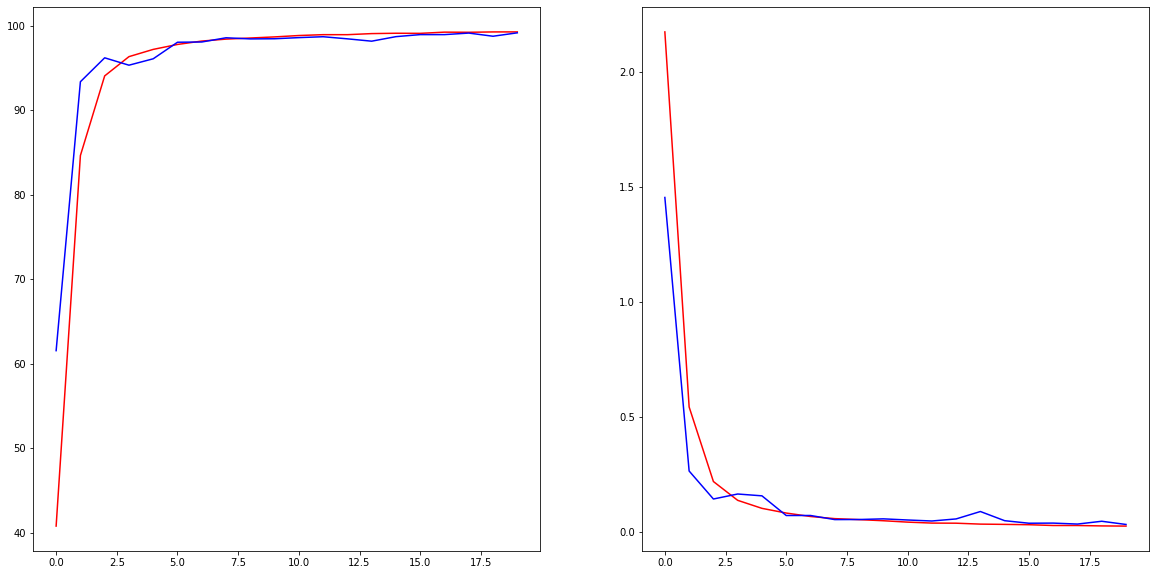

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# X coordinate for plotting
x = np.arange(numEpoch)

plt.figure(figsize=(20,10))

# Train is red, validation is blue
plt.subplot(1,2,1)
plt.plot(x,train_accs,'r')
plt.plot(x,val_accs,'b')

plt.subplot(1,2,2)
plt.plot(x,train_losses,'r')
plt.plot(x,val_losses,'b')

plt.show()




# Load model and classify image

In [22]:
from PIL import Image

model = torch.load("./model.pth")
model.eval()

transform = transforms.Compose([transforms.ToTensor()]) 

img = Image.open("/content/img4.jpg")  
x = transform(img)  # Preprocess image
x = x.unsqueeze(0)  # Add batch dimension
x=x.cuda()

output = model(x)  # Forward pass
_, pred = torch.max(output, 0)  # Get predicted class if multi-class classification

print('Image predicted as: ', subclassNames[0][pred.item()])
print(torch.max(output,0))


Image predicted as:  Parking
torch.return_types.max(
values=tensor(5.7150, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(43, device='cuda:0'))


# Croping image from annotations.pickle

[[142, 394, 95, 170, 1, 1, -0.17326607861387497, -0.14893129554855603, 0.609], [267, 145, 94, 164, 2, 2, -0.07035119493500877, 0.15015939029792616, 0.899], [344, 300, 131, 225, 2, 2, 0.025862755947080488, -0.04726275758071938, 0.53], [442, 96, 103, 190, 2, 1, 0.17282128656304138, 0.20362687852719613, 0.8210000000000001], [47, 104, 42, 29, 0, 48, -0.37242543557607266, 0.1981708144813499, 0.844], [93, 100, 35, 31, 0, 53, -0.3131142166962385, 0.20688945743716738, 0.857], [66, 131, 36, 32, 0, 45, -0.3582628464250041, 0.16620892522432462, 0.874], [115, 129, 36, 29, 0, 47, -0.29023098256567753, 0.170646059402021, 0.882], [547, 110, 43, 38, 0, 33, 0.2540454786517823, 0.1488718540303369, 0.662], [610, 104, 51, 40, 0, 6, 0.3131076528169512, 0.15074130675003156, 0.642], [624, 141, 32, 38, 0, 4, 0.33866510498923713, 0.11512403659289916, 0.663], [570, 146, 43, 35, 0, 23, 0.28633788186991205, 0.11229059172906777, 0.679]]
Image predicted as:  No stopping
Image predicted as:  Go around either way
Ima

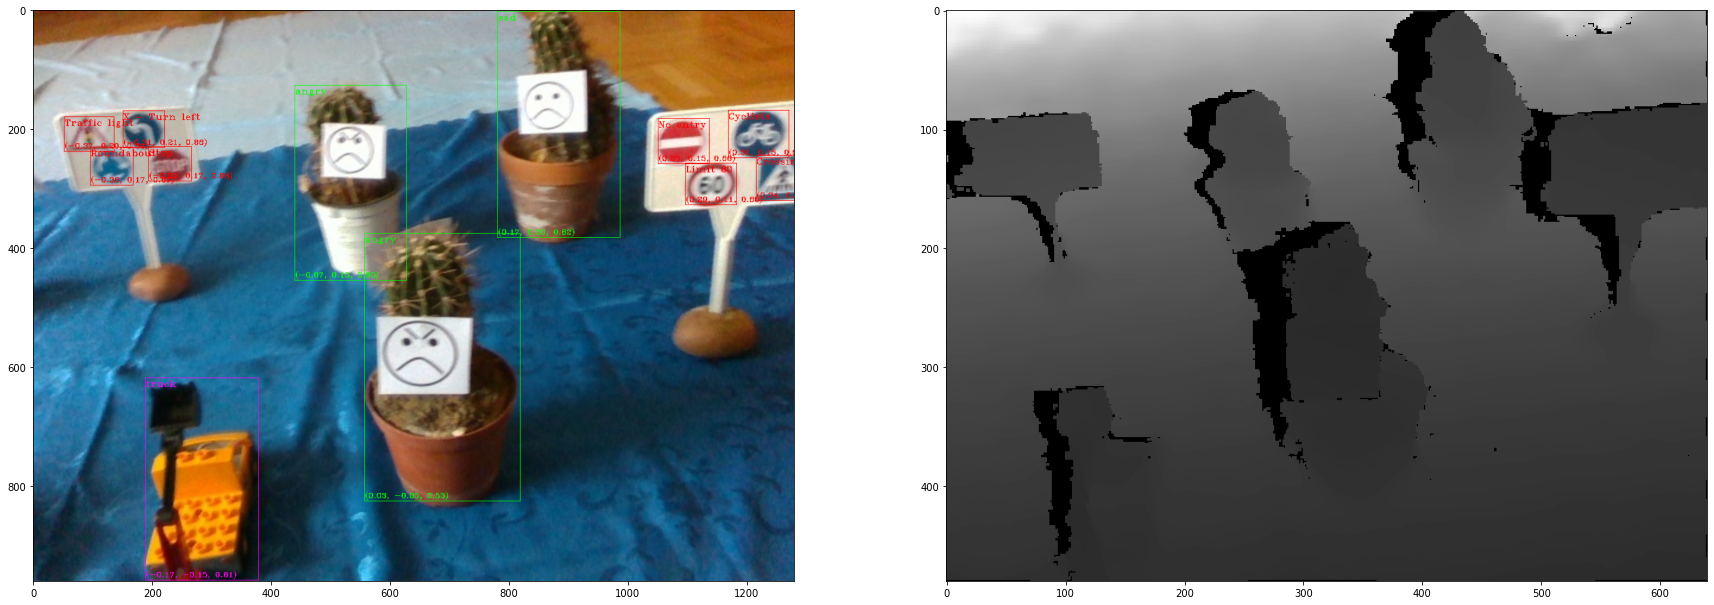

In [19]:

colors = [(0,0,255),(255,0,255),(0,255,0)]

transform = transforms.Compose([transforms.ToTensor()]) 

def drawBBs(BBs, img):
    img = cv2.resize(img, (1280, 960))
    #i=0
    for BB in BBs:
        u = BB[0]*2
        v = BB[1]*2
        w = BB[2]*2
        h = BB[3]*2
        c = BB[4]
        sc = BB[5]
        x = BB[6]
        y = BB[7]
        z = BB[8]
        s = (u - w // 2, v - h // 2)
        e = (u + w // 2, v + h // 2)
        if c==0:      #if class is traffic sign then
          crop_image = img[v-w//2:v+w//2, u-h//2:u+h//2]
          rs_img=cv2.resize(crop_image, (32,32), interpolation = cv2.INTER_AREA)
          rs_img_rgb= cv2.cvtColor(rs_img,cv2.COLOR_BGR2RGB)
         
          #i=i+1
          #cv2.imwrite('img36'+str(i)+'.jpg',rs_img)
          #plt.imshow(rs_img_rgb)
          #im_pil = Image.fromarray(rs_img_rgb)
          
          dl_img = transform(rs_img_rgb)  # Preprocess image
          dl_img = dl_img.unsqueeze(0)  # Add batch dimension
          if haveCuda:
            dl_img=dl_img.cuda()
          output = model(dl_img)  # Forward pass
          _, pred = torch.max(output, 0)  # Get predicted class
          print('Image predicted as: ', subclassNames[0][pred.item()])

        cv2.rectangle(img, s, e, colors[c], 1)
        tl = (s[0], s[1]+15)
        bl = (s[0], e[1]-5)
        cv2.putText(img,subclassNames[c][sc],tl,cv2.FONT_HERSHEY_COMPLEX_SMALL,0.75,colors[c])
        coords = "(%.2f, %.2f, %.2f)" % (x,y,z)
        cv2.putText(img,coords,bl,cv2.FONT_HERSHEY_COMPLEX_SMALL,0.65,colors[c])
    
    return img

import pickle
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch import optim
import numpy as np
%matplotlib inline

# Read images
img = cv2.imread("HW/g3/rgb/250.jpg")
depth = cv2.imread("HW/g3/depth/250.png", -1)
#Read model
model = torch.load("./model.pth")
model.eval()

# Read annotations
file = open('HW/annotations.pickle','rb')
annotations = pickle.load(file)
print (annotations["HW/g3/rgb/250.jpg"]["objects"])

# Visualization
depth = depth / 5000.0
img = drawBBs(annotations["HW/g3/rgb/250.jpg"]["objects"], img)
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Figure with subplots
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.subplot(1,2,2)
plt.imshow(depth,cmap='gray')